***
# Starting Kit - Black Swan HiggsML Course
***

In [ ]:
COLAB = "google.colab" in str(get_ipython())

In [ ]:
if COLAB:
    ! git clone --depth 1 https://github.com/blackSwanCS/Higgs_collaboration_B.git
    ! git status
    %cd /Higgs_collaboration_B

In [ ]:
# HiggsML utility package should not be modified
%pip install HiggsML

### Imports

In [1]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys

warnings.filterwarnings("ignore")

### Directories

In [2]:
root_dir = os.getcwd()
print("Root directory is", root_dir)
submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Root directory is c:\Users\marti\Documents\1A CS\Higgs\Higgs_collaboration_B


## Import Submission Model
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements a basic model with 2 different model trained to predict the class label. 

* 1 XGBoost BDT ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/boosted_decision_tree.py) )
* 2 Tebsorflow NN  ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/neural_network.py) )

The feature engineering is in where you can include derived quantities and decide which feature should be needed. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/feature_engineering.py) ) 

the statistical analysis part is where yoiu write the mu finding calculation using the output of the classifier. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/statistical_analysis.py) ) 

If running in Collab, click the folder icon in the left sidebar to open the file browser.


In [3]:
path.append(submission_dir)
from model import Model

## Data
### Available data sets
1. blackSwan_data
2. sample_data
3. neurips2024_data 

In [4]:
from HiggsML.datasets import download_dataset

data = download_dataset(
    "blackSwan_data"
)  # change to "blackSwan_data" for the actual data

2025-06-03 16:22:30,384 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-03 16:22:30,386 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\marti\Documents\1A CS\Higgs\Higgs_collaboration_B
2025-06-03 16:22:30,391 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-03 16:22:30,392 - HiggsML.datasets     - INFO     - Test size: 600000


### ⚠️ Note:
The data used here is a small subset of the full data is for demonstration only to get a view of what the data looks like. 

In [5]:
# load train set
data.load_train_set()
data_set = data.get_train_set()

2025-06-03 16:08:30,371 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-03 16:08:31,862 - HiggsML.datasets     - INFO     - Data loaded successfully


***
## Visualize the Data Set
***

In [ ]:
from tabulate import tabulate

target = data_set["labels"]
weights = data_set["weights"]
detailed_label = data_set["detailed_labels"]
keys = np.unique(detailed_label)


weight_keys = {}
average_weights = {}
for key in keys:
    weight_keys[key] = weights[detailed_label == key]

table_data = []
for key in keys:
    table_data.append(
        [
            key,
            np.sum(weight_keys[key]),
            len(weight_keys[key]),
            np.mean(weight_keys[key]),
        ]
    )

table_data.append(
    [
        "Total Signal",
        np.sum(weights[target == 1]),
        len(weights[target == 1]),
        np.mean(weights[target == 1]),
    ]
)
table_data.append(
    [
        "Total Background",
        np.sum(weights[target == 0]),
        len(weights[target == 0]),
        np.mean(weights[target == 0]),
    ]
)


print("[*] --- Detailed Label Summary")
print(
    tabulate(
        table_data,
        headers=[
            "Detailed Label",
            "Total Weight",
            "Number of events",
            "Average Weight",
        ],
        tablefmt="grid",
    )
)

In [ ]:
print("\n[*] --- Examples of all features\n")
display(data_set.head())

In [ ]:
print("\n[*] --- Description of all features\n")
display(data_set.describe())

In [ ]:
from utils import histogram_dataset

# this function is defined in utils.py in the sample_code_submission directory. feel free to modify it as needed

histogram_dataset(
    data_set,
    target,
    weights,
    columns=["PRI_lep_phi", "PRI_met", "DER_mass_vis", "DER_deltaeta_jet_jet"],
)

In [ ]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (10, 10)}, style="whitegrid")

caption = ["Signal feature", "Background feature"]

for i in range(2):

    dfplot = pd.DataFrame(
        data_set,
        columns=[
            "PRI_lep_phi",
            "PRI_met",
            "DER_pt_ratio_lep_had",
            "DER_deltaeta_jet_jet",
        ],
    )

    print(caption[i], " correlation matrix")
    corrMatrix = dfplot[target == i].corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.title("Correlation matrix of features")
    plt.show()

del dfplot

In [ ]:
from HiggsML.visualization import stacked_histogram

stacked_histogram(data_set, target, weights, detailed_label, "PRI_jet_subleading_pt")

In [ ]:
from HiggsML.visualization import pair_plots

# Show data summary
pair_plots(
    data_set,
    target,
    sample_size=100,
    columns=[
        "PRI_lep_phi",
        "PRI_met",
        "DER_lep_eta_centrality",
        "DER_deltaeta_jet_jet",
    ],
)

### Test Settings
The Test setting sets the test conditions in ingestion.
This includes what systematics you want and how many psuedo experiments you want. 

In [5]:
TEST_SETTINGS = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 25,  # Number of pseudo-experiments to run per set
    "num_of_sets": 25,  # Number of sets of pseudo-experiments to run
}

RANDOM_SEED = 42

In [6]:
test_settings = TEST_SETTINGS.copy()

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)

### Ingestion



In [7]:
from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)

In [8]:
# initialize submission
ingestion.init_submission(Model,"NN")

2025-06-03 16:22:41,604 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-06-03 16:22:41,610 - HiggsML.datasets     - INFO     - Selected train size: 5000
2025-06-03 16:22:42,154 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-03 16:22:42,183 - HiggsML.datasets     - INFO     - Selected train size: 5000


Training Data:  (5000, 28)
Training Labels:  (5000,)
Training Weights:  (5000,)
sum_signal_weights:  642.7306335803532
sum_bkg_weights:  105076.26936641964


2025-06-03 16:22:42,641 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-03 16:22:42,672 - HiggsML.datasets     - INFO     - Selected train size: 5000



Valid Data:  (5000, 28)
Valid Labels:  (5000,)
Valid Weights:  (5000,)
sum_signal_weights:  690.2102996947064
sum_bkg_weights:  105028.7897003053


2025-06-03 16:22:43,131 - HiggsML.datasets     - INFO     - Data loaded successfully



Holdout Data:  (5000, 28)
Holdout Labels:  (5000,)
Holdout Weights:  (5000,)
sum_signal_weights:  668.9439676877885
sum_bkg_weights:  105050.05603231218
 
 
Training Data:  (5000, 28)
DEBUG: model_type = 'NN'
 Model is NN


2025-06-03 16:22:51,494 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model


Epoch 1/5
157/157 - 2s - 15ms/step - accuracy: 0.6526 - loss: 28.1109
Epoch 2/5
157/157 - 0s - 3ms/step - accuracy: 0.7282 - loss: 24.3404
Epoch 3/5
157/157 - 1s - 4ms/step - accuracy: 0.7660 - loss: 22.6680
Epoch 4/5
157/157 - 1s - 4ms/step - accuracy: 0.7690 - loss: 21.8723
Epoch 5/5
157/157 - 1s - 4ms/step - accuracy: 0.7706 - loss: 21.4513


2025-06-03 16:22:56,203 - absl                 - WARNING  - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Model saved to {path}
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score shape before threshold (4573,)
score shape after threshold (4573,)
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
saved_info {'beta': np.float64(21842.4289109693), 'gamma': np.float64(500.6406119689328), 'tes_fit': <function tes_fitter.<locals>.fit_function at 0x00000254379D8540>, 'jes_fit': <function jes_fitter.<locals>.fit_function at 0x00000254379D8220>}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Results: 
	 mu_hat  :  -0.4100146158989009
	 del_mu_stat  :  0.29856943189157253
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.29856943189157253
Holdout Results: 
	 mu_hat  :  1.0000000000000109
	 del_mu_stat  :  0.29856943189157253
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.29856943189157253
Valid Results: 
	 mu_hat  :  0.8714605909166792
	 del_mu_stat  :  0.29856943189157253
	 del_mu_sys  :  0.0
	 del_mu_tot  :

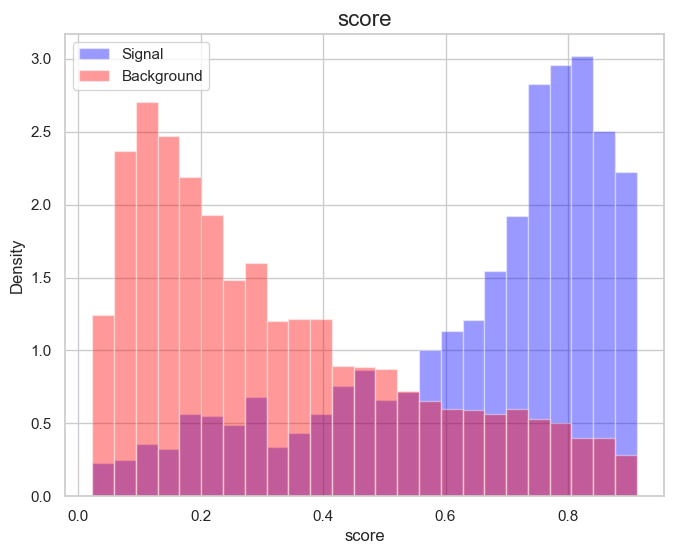

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


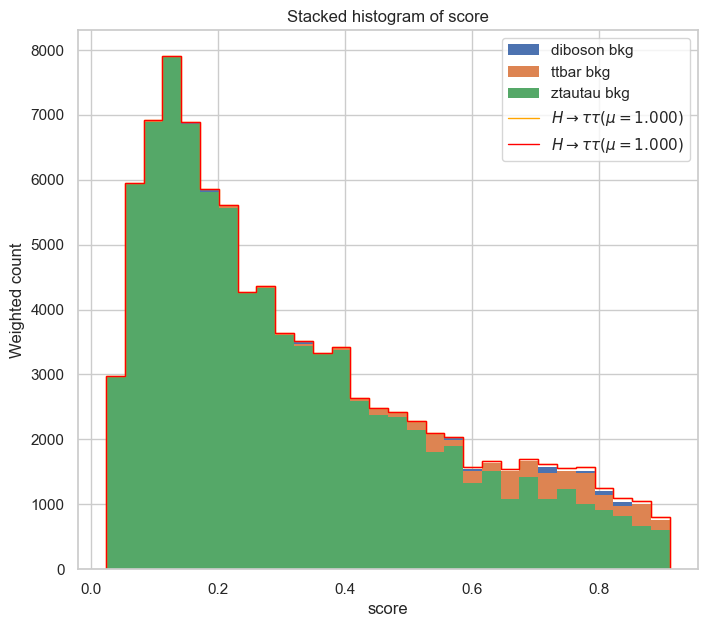

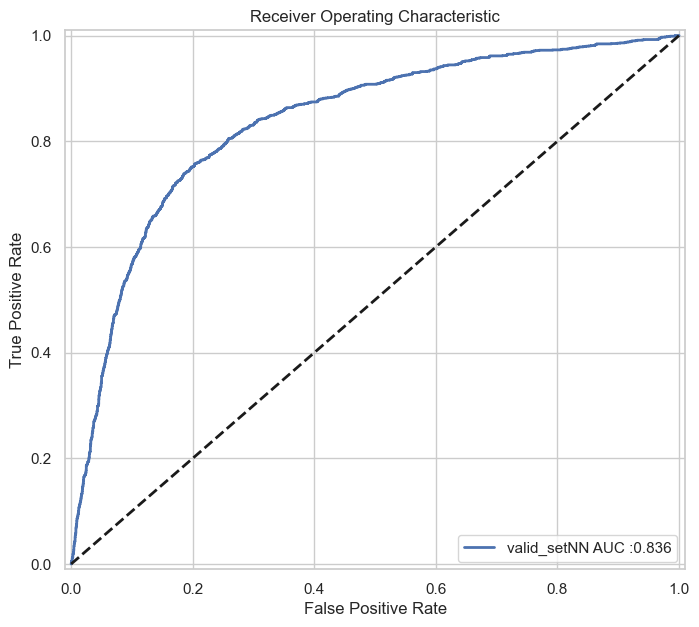

In [9]:
# fit submission
ingestion.fit_submission()

In [ ]:
# load test set
data.load_test_set()

In [ ]:
# predict submission
ingestion.predict_submission(test_settings)

In [ ]:
ingestion.process_results_dict()

In [ ]:
# save result
ingestion.save_result(output_dir)

## Score
1. Compute Scores
2. Visualize Scores


In [ ]:
from HiggsML.score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
print(output_dir)
score.load_ingestion_results(prediction_dir=output_dir, score_dir=output_dir)

In [ ]:
# Compute Score
score.compute_scores(test_settings)

In [ ]:
from HiggsML.visualization import visualize_scatter

# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(
    ingestion_result_dict=ingestion.results_dict,
    ground_truth_mus=test_settings["ground_truth_mus"],
)

In [ ]:
!python -m HiggsML.score --prediction $output_dir --output $output_dir